In [64]:
!pip install pmdarima

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [66]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('https://raw.githubusercontent.com/BhavanishDhamnaskar/gg_stk/main/GOOGLE.csv')
df

,Date,Open,High,Low,Close,Volume
0,2004-08-19,2.502503,2.604104,2.401401,2.511011,893181924
1,2004-08-20,2.527778,2.729730,2.515015,2.710460,456686856
2,2004-08-23,2.771522,2.839840,2.728979,2.737738,365122512
3,2004-08-24,2.783784,2.792793,2.591842,2.624374,304946748
4,2004-08-25,2.626627,2.702703,2.599600,2.652653,183772044
...,...,...,...,...,...,...
4712,2023-05-09,108.389999,110.150002,107.190002,107.349998,36360100
4713,2023-05-10,107.970001,112.940002,107.930000,111.750000,63153400
4714,2023-05-11,115.400002,117.919998,114.410004,116.570000,78900000
4715,2023-05-12,116.680000,118.029999,116.110001,117.510002,41073800


In [67]:
# Converting the Date column data type from object to datetime
df['Date'] = pd.to_datetime(df['Date'], errors = 'coerce', dayfirst = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4717 entries, 0 to 4716
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4717 non-null   datetime64[ns]
 1   Open    4717 non-null   float64       
 2   High    4717 non-null   float64       
 3   Low     4717 non-null   float64       
 4   Close   4717 non-null   float64       
 5   Volume  4717 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 221.2 KB


In [68]:
df.head()

,Date,Open,High,Low,Close,Volume
0,2004-08-19,2.502503,2.604104,2.401401,2.511011,893181924
1,2004-08-20,2.527778,2.729730,2.515015,2.710460,456686856
2,2004-08-23,2.771522,2.839840,2.728979,2.737738,365122512
3,2004-08-24,2.783784,2.792793,2.591842,2.624374,304946748
4,2004-08-25,2.626627,2.702703,2.599600,2.652653,183772044


# EDA

In [69]:
correlation_matrix = df.corr(numeric_only=True)

fig = px.imshow(correlation_matrix,
                color_continuous_scale='RdBu',
                zmin=-1, zmax=1,
                labels=dict(color="Correlation"),
                x=correlation_matrix.columns,
                y=correlation_matrix.columns)
fig.update_layout(width=600, height=500)
fig.show()

In [70]:
df['open-high'] = df['Open']-df['High']
df['open-low'] = df['Open'] - df['Low']
df['open-close'] = df['Open'] - df['Close']
df.head()

,Date,Open,High,Low,Close,Volume,open-high,open-low,close-high,close-low,high-low,open-close
0,2004-08-19,2.502503,2.604104,2.401401,2.511011,893181924,-0.101601,0.101102,-0.093093,0.109610,0.202703,-0.008508
1,2004-08-20,2.527778,2.729730,2.515015,2.710460,456686856,-0.201952,0.012763,-0.019270,0.195445,0.214715,-0.182682
2,2004-08-23,2.771522,2.839840,2.728979,2.737738,365122512,-0.068318,0.042543,-0.102102,0.008759,0.110861,0.033784
3,2004-08-24,2.783784,2.792793,2.591842,2.624374,304946748,-0.009009,0.191942,-0.168419,0.032532,0.200951,0.159410
4,2004-08-25,2.626627,2.702703,2.599600,2.652653,183772044,-0.076076,0.027027,-0.050050,0.053053,0.103103,-0.026026


In [71]:
data2 = df.copy()
numeric_columns = data2.select_dtypes(include='number').columns
data2 = data2[numeric_columns]

fig = px.imshow(data2.corr(), color_continuous_scale='Blues')
fig.update_layout(
    title='Correlation Heatmap',
    xaxis_title='Columns',
    yaxis_title='Columns',
)
fig.show()

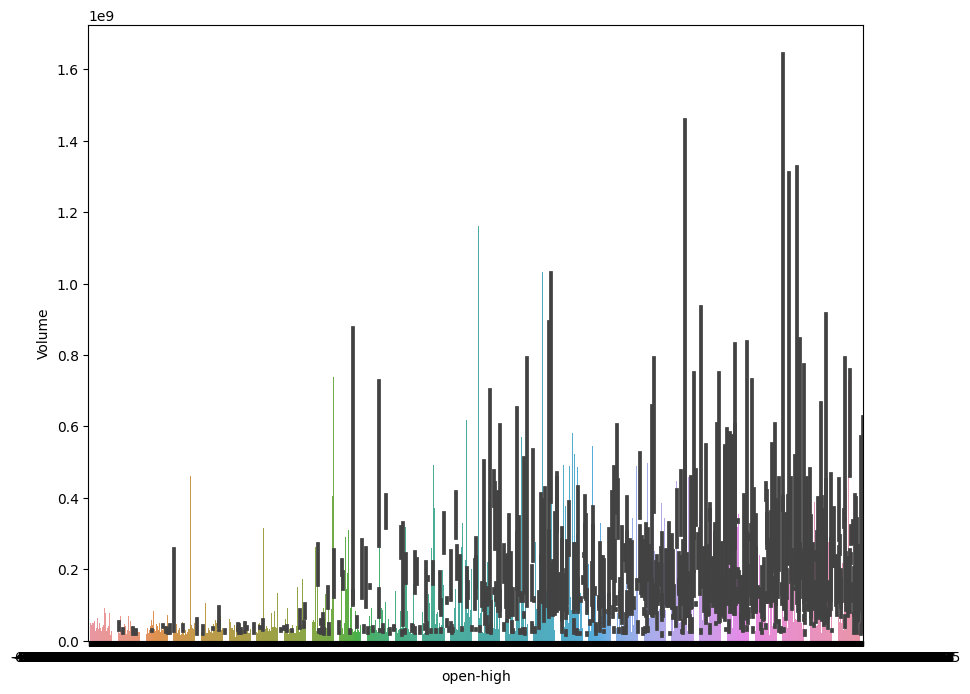

In [72]:
plt.figure(figsize=(10, 8))

sns.barplot(data=df, x="open-high", y="Volume")

plt.show()

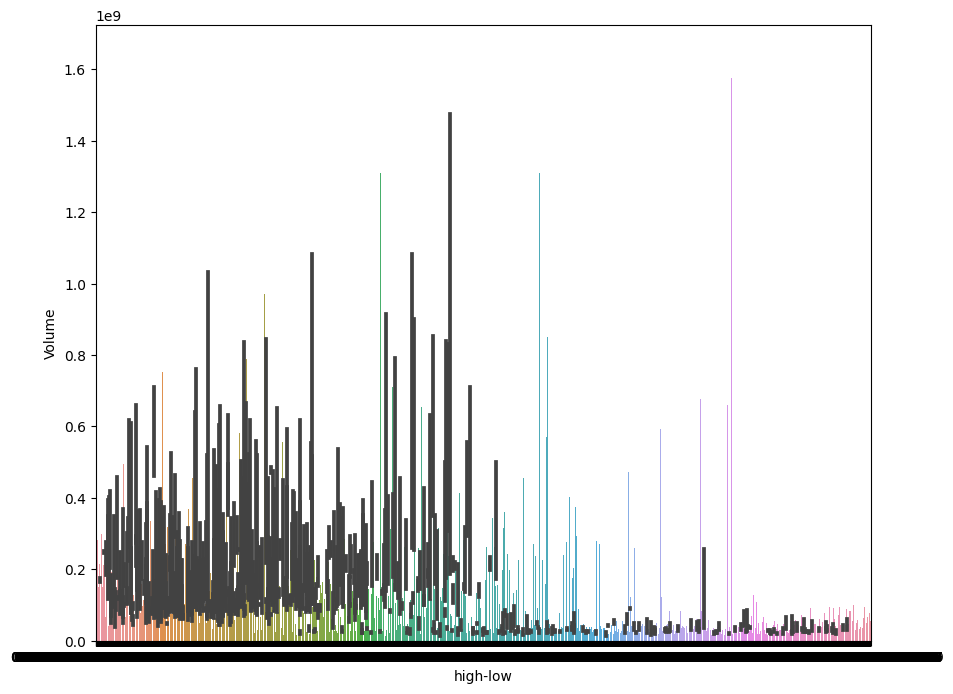

In [73]:
plt.figure(figsize=(10, 8))
sns.barplot(data=df, x="high-low", y="Volume")

plt.show()

# ARIMA Model

In [74]:
fig = go.Figure(data=go.Scatter(x=df.index, y=df['Close']))
fig.update_layout(title='https://raw.githubusercontent.com/BhavanishDhamnaskar/gg_stk/main/GOOGLE.csv', xaxis_title='Date', yaxis_title='Close Prices')
fig.show()

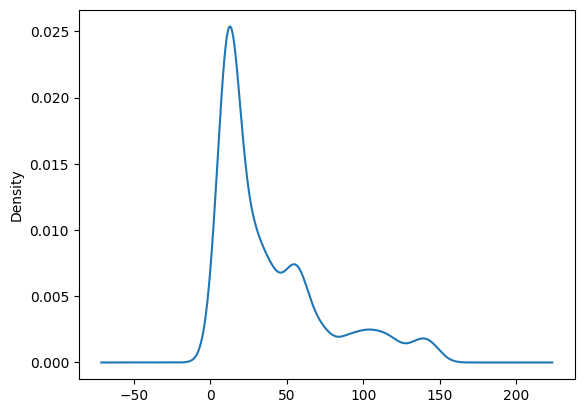

In [75]:
#Distribution of the dataset
df_close = df['Close']
df_close.plot(kind='kde');

In [76]:
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    # Create figure
    fig = go.Figure()

    # Add original timeseries trace
    fig.add_trace(go.Scatter(x=timeseries.index, y=timeseries, name='Original', mode='lines'))

    # Add rolling mean trace
    fig.add_trace(go.Scatter(x=rolmean.index, y=rolmean, name='Rolling Mean', mode='lines'))

    # Add rolling std trace
    fig.add_trace(go.Scatter(x=rolstd.index, y=rolstd, name='Rolling Std', mode='lines'))

    # Update layout
    fig.update_layout(title='Rolling Mean and Standard Deviation', xaxis_title='Time', yaxis_title='Value')

    # Show the figure
    fig.show()

    print("Results of Dickey-Fuller test")
    adft = adfuller(timeseries, autolag='AIC')
    output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, value in adft[4].items():
        output['critical value (%s)' % key] = value
    print(output)

test_stationarity(df_close)

Results of Dickey-Fuller test
Test Statistics                   0.479840
p-value                           0.984247
No. of lags used                 31.000000
Number of observations used    4685.000000
critical value (1%)              -3.431747
critical value (5%)              -2.862157
critical value (10%)             -2.567098
dtype: float64


In [77]:
result = seasonal_decompose(df_close, model='multiplicative', period=30)

# Create subplots with shared x-axis
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.1)

# Add original series
fig.add_trace(go.Scatter(x=df_close.index, y=df_close, name='Original'), row=1, col=1)

# Add trend component
fig.add_trace(go.Scatter(x=result.trend.index, y=result.trend, name='Trend'), row=2, col=1)

# Add seasonal component
fig.add_trace(go.Scatter(x=result.seasonal.index, y=result.seasonal, name='Seasonal'), row=3, col=1)

# Add residual component
fig.add_trace(go.Scatter(x=result.resid.index, y=result.resid, name='Residual'), row=4, col=1)

# Set subplot titles
fig.update_yaxes(title_text='Original', row=1, col=1)
fig.update_yaxes(title_text='Trend', row=2, col=1)
fig.update_yaxes(title_text='Seasonal', row=3, col=1)
fig.update_yaxes(title_text='Residual', row=4, col=1)

# Set overall figure size
fig.update_layout(height=800, width=1000, title_text='Time Series Decomposition')

# Show the plot
fig.show()

In [78]:
# Convert the series to logarithmic scale
df_log = np.log(df_close)

# Calculate moving average and standard deviation
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()

# Create a trace for standard deviation
trace_std_dev = go.Scatter(x=df_close.index, y=std_dev, name='Standard Deviation', line=dict(color='black'))

# Create a trace for moving average
trace_moving_avg = go.Scatter(x=df_close.index, y=moving_avg, name='Mean', line=dict(color='red'))

# Create the figure layout
layout = go.Layout(
    title='Moving Average',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Value'),
    showlegend=True
)

# Create the figure object
fig = go.Figure(data=[trace_std_dev, trace_moving_avg], layout=layout)

# Show the plot
fig.show()

In [79]:
train_data = df_log[3:int(len(df_log)*0.9)]
test_data = df_log[int(len(df_log)*0.9):]

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data.index, y=train_data, mode='lines', name='Train data'))
fig.add_trace(go.Scatter(x=test_data.index, y=test_data, mode='lines', name='Test data'))

fig.update_layout(
    title='Closing Prices',
    xaxis_title='Dates',
    yaxis_title='Closing Prices'
)

fig.show()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=21901.220, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=1.22 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.80 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-21558.106, Time=2.61 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=4.54 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-21556.327, Time=3.73 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=1.55 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=2.47 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=7.34 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-21548.557, Time=2.83 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 27.283 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4242
Model:               SARIMAX(1, 0, 1)   Log Likelihood               10782.053
Date:

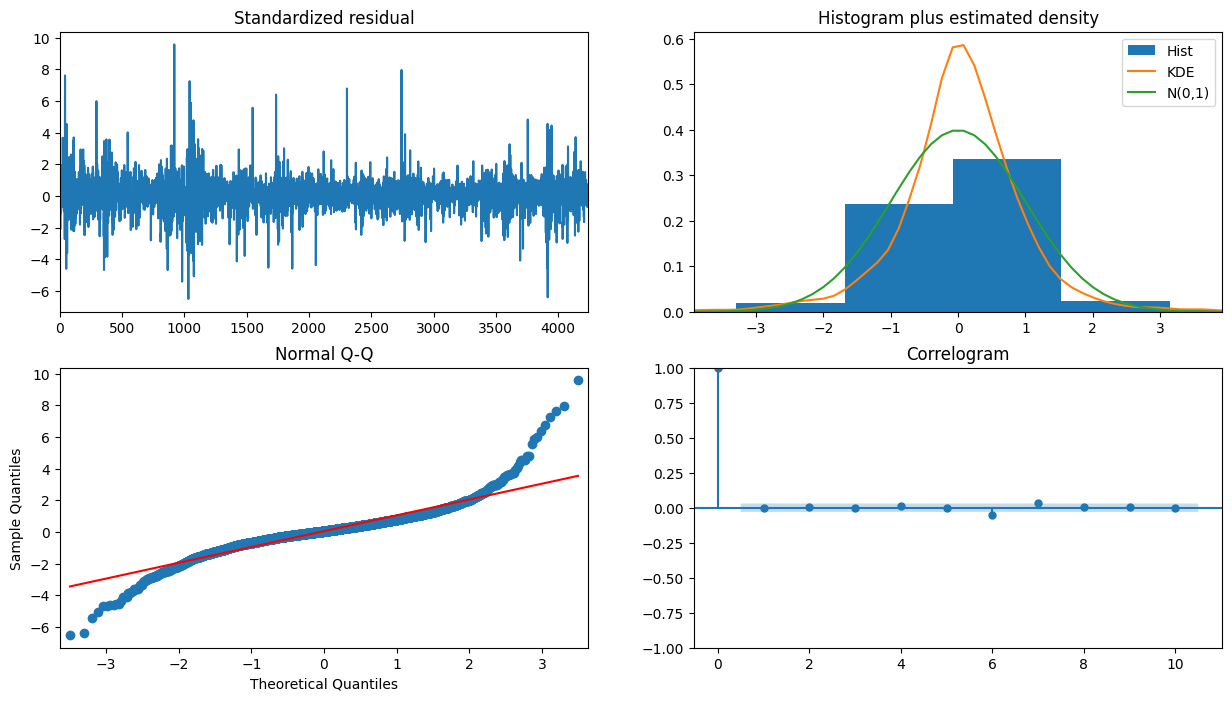

In [80]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show();

In [81]:
from statsmodels.tsa.arima.model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 2))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4242
Model:                 ARIMA(1, 1, 2)   Log Likelihood               10784.801
Date:                Tue, 05 Dec 2023   AIC                         -21561.603
Time:                        17:56:50   BIC                         -21536.193
Sample:                             0   HQIC                        -21552.622
                               - 4242                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0686      1.386      0.050      0.961      -2.647       2.784
ma.L1         -0.0900      1.386     -0.065      0.948      -2.806       2.626
ma.L2          0.0094      0.030      0.309      0.7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



# GBM

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



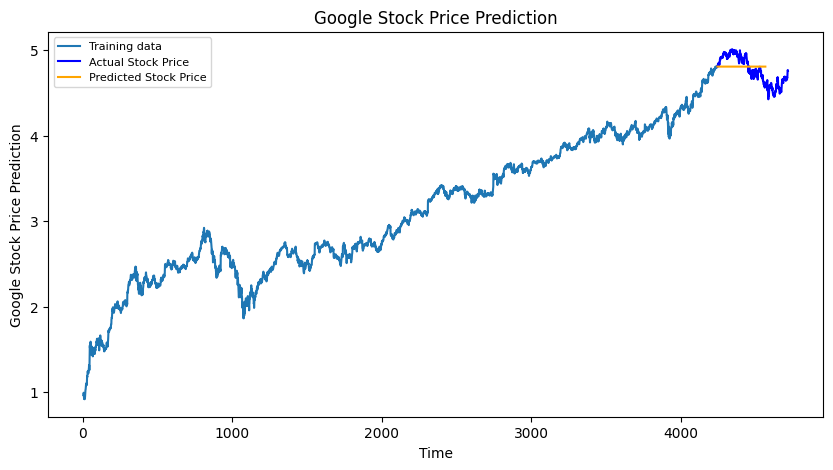

In [82]:
forecasted_values = fitted.forecast(321, alpha=0.05)

fc_series = pd.Series(forecasted_values, index=test_data.index)

plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='Training data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price Prediction')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [83]:
open_values = df.Open

In [84]:
train_data = open_values[3931:4201].values
test_data  = open_values[4201:4261].values

In [85]:
t = range(len(train_data))
t2 = range(len(test_data))

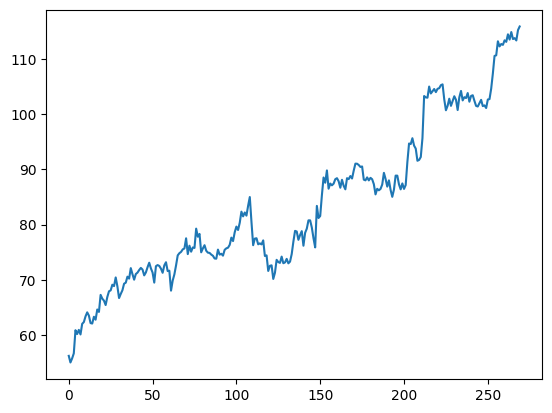

In [86]:
plt.plot(t,train_data)
plt.show()

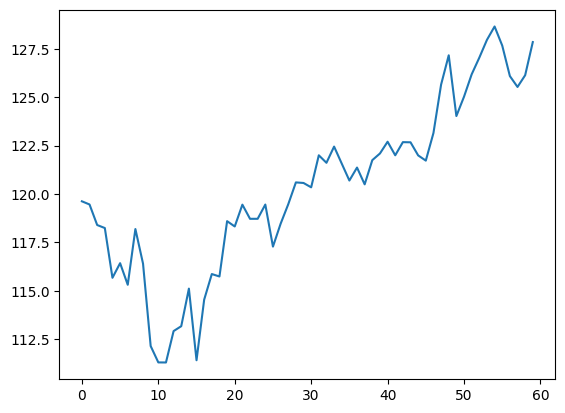

In [87]:
plt.plot(t2,test_data)
plt.show()

Obtention of mu and sigma

In [88]:
returns = np.zeros(len(train_data)-1)
for i in range(len(returns)):
    returns[i] = math.log(train_data[i+1] /train_data[i])

In [89]:
mu    = np.mean(returns)
sigma = np.std(returns)
print("The approximation of the expected daily return is: "+ str(mu))
print("The approximation of the volatility is: "+ str(sigma))

The approximation of the expected daily return is: 0.002690153689774719
The approximation of the volatility is: 0.019018831617742787


Generation of trajectories

In [90]:
S = np.zeros((100,len(test_data)))
W = np.zeros((100, len(test_data)))

In [91]:
for i in range(100):
    W[i] = np.random.normal(0,1,len(test_data))

In [92]:
for i in range(100):
    S[i][0] = train_data [len(train_data)-1] + mu* train_data [len(train_data)-1] + sigma * train_data[len(train_data)-1] * W[i][0]

In [93]:
for i in range(100):
    for j in range(len(test_data)-1):
        S[i][j+1] = S[i][j] + mu*S[i][j] + sigma*S[i][j]*W[i][j]

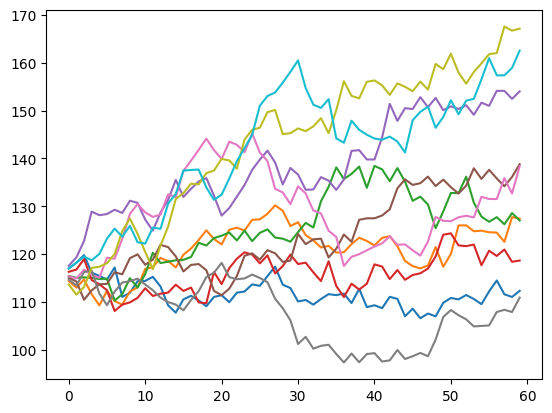

In [94]:
for i in range(10):
    plt.plot(t2, S[i,:])

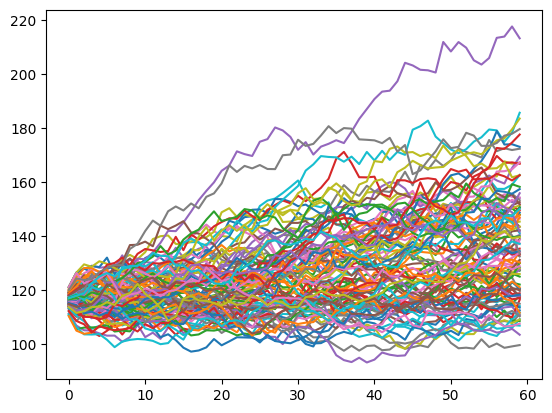

In [95]:
for i in range(100):
    plt.plot(t2,S[i,:])

Computation with the trajectories

In [96]:
M = np.zeros(len(test_data))
for i in range(len(test_data)):
    M[i] = np.mean(S[: , i])

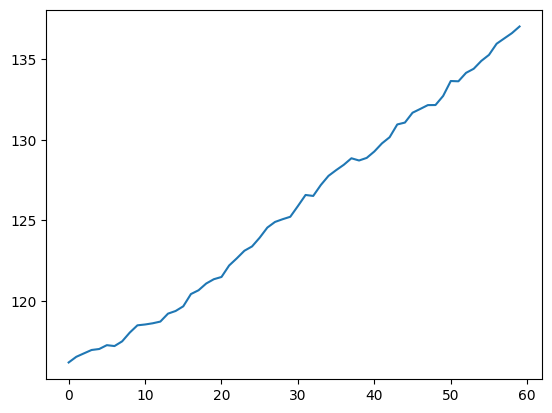

In [97]:
plt.plot(t2,M)

# LinearReg

In [98]:
# Using the LinearRegression for the Predictions
from sklearn.linear_model import LinearRegression
regression = LinearRegression()

In [106]:
# Min and Max Date in the given Dataset
df['Date'].min(), df['Date'].max()

(Timestamp('2004-08-19 00:00:00'), Timestamp('2023-05-15 00:00:00'))

In [109]:
# As it is a Time driven data so we need to divide the given Dataset into 70-30 ratio using the Date column
train_df = df.loc[df['Date'] < '2017-10-01'].copy()
test_df = df.loc[df['Date'] >= '2017-10-01'].copy()

train_df.shape, test_df.shape

((3303, 12), (1414, 12))

In [113]:
# Verify that 'train_data' is a pandas DataFrame
print(type(train_df))

# Check for the presence of the columns in 'train_data'
print(train_df.columns)

# Confirm that all predictor columns are in the DataFrame
print(all(column in train_df.columns for column in predictors))

# Confirm that the target column is in the DataFrame
print(target[0] in train_df.columns)

# If all checks pass, try fitting the regression model again
if all(column in train_df.columns for column in predictors + target):
    regression.fit(train_df[predictors], train_df[target])
else:
    print("One or more columns are missing in the DataFrame.")


<class 'pandas.core.frame.DataFrame'>
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'open-high',
       'open-low', 'close-high', 'close-low', 'high-low', 'open-close'],
      dtype='object')
True
True


In [116]:
# Ensure that 'test_df' is a pandas DataFrame
print(type(test_df))

# Check if the predictor columns exist in 'test_df'
print(test_df.columns)
print(all(column in test_df.columns for column in predictors))

# If the checks pass, make the prediction
if all(column in test_df.columns for column in predictors):
    predictions = regression.predict(test_df[predictors])

    # Ensure 'test_data' is the DataFrame where you want to add predictions
    # And also it must be a pandas DataFrame
    print(type(test_df))

    # Check the length of 'predictions' and 'test_data' match
    print(len(predictions), len(test_df))

    # If 'predictions' is a pandas Series or a numpy array with a single column,
    # it can be directly assigned to 'test_data' as a new column
    if len(predictions) == len(test_df):
        test_df['Prediction'] = predictions
    else:
        print("The length of predictions does not match the number of rows in 'test_data'.")
else:
    print("One or more predictor columns are missing in 'test_df'.")


<class 'pandas.core.frame.DataFrame'>
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'open-high',
       'open-low', 'close-high', 'close-low', 'high-low', 'open-close'],
      dtype='object')
True
<class 'pandas.core.frame.DataFrame'>
1414 1414


In [118]:
predictors = ['Open', 'High', 'Low', 'Volume']
target = ['Close']

regression.fit(train_df[predictors], train_df[target])

LinearRegression()

In [119]:
predictions = regression.predict(test_df[predictors])
test_df['Prediction'] = predictions

In [120]:
test_df.head()

,Date,Open,High,Low,Close,Volume,open-high,open-low,close-high,close-low,high-low,open-close,Prediction
3303,2017-10-02,48.782501,48.887001,48.097500,48.373501,30782000,-0.104500,0.685001,-0.513500,0.276001,0.789501,0.409000,48.366900
3304,2017-10-03,48.377998,48.622002,48.135502,48.604000,21666000,-0.244004,0.242496,-0.018002,0.468498,0.486500,-0.226002,48.410591
3305,2017-10-04,48.588001,48.720001,48.280499,48.339001,21156000,-0.132000,0.307502,-0.381000,0.058502,0.439502,0.249000,48.483289
3306,2017-10-05,48.639500,49.325500,48.513500,49.259499,35618000,-0.686000,0.126000,-0.066001,0.745999,0.812000,-0.619999,49.107592
3307,2017-10-06,49.000000,49.713001,48.925499,49.681999,31060000,-0.713001,0.074501,-0.031002,0.756500,0.787502,-0.681999,49.528951


In [121]:
test_df.tail()

,Date,Open,High,Low,Close,Volume,open-high,open-low,close-high,close-low,high-low,open-close,Prediction
4712,2023-05-09,108.389999,110.150002,107.190002,107.349998,36360100,-1.760003,1.199997,-2.800004,0.159996,2.960000,1.040001,108.923929
4713,2023-05-10,107.970001,112.940002,107.930000,111.750000,63153400,-4.970001,0.040001,-1.190002,3.820000,5.010002,-3.779999,111.904391
4714,2023-05-11,115.400002,117.919998,114.410004,116.570000,78900000,-2.519996,0.989998,-1.349998,2.159996,3.509994,-1.169998,116.696048
4715,2023-05-12,116.680000,118.029999,116.110001,117.510002,41073800,-1.349999,0.569999,-0.519997,1.400001,1.919998,-0.830002,117.383901
4716,2023-05-15,116.110001,118.480003,116.010002,116.510002,36226100,-2.370002,0.099999,-1.970001,0.500000,2.470001,-0.400001,117.971640


In [122]:
# Plotting the Actual Close and Predicted Close using the Line Chart
px.line(test_df, x = 'Date', y = ['Close', 'Prediction'], title = 'Actual Close vs Predicted for Stock GOOGLE')

In [123]:
# Errors
residuals = test_df['Close'] - test_df['Prediction']
px.scatter(residuals, trendline = 'ols')

In [126]:
# Trying to predict for the NEXT date
last_row = test_df.iloc[-1]

# Create a dictionary with the feature names and values for the next day
next_day_dict = {
    'Open': last_row['Close'],
    'High': last_row['Close'] + 1,
    'Low': last_row['Close'] - 1,
    'Volume': last_row['Volume'] * 1.2
}

# Convert the dictionary into a list
next_day = [list(next_day_dict.values())]

regression.fit(train_df[predictors], train_df[target])

# Predict the close price for the next day
predicted_close = regression.predict(next_day)[0]

# Update the 'Close' value in the next_day dictionary with the predicted value
next_day_dict['Close'] = predicted_close

print("Features for the next day: ", next_day_dict)
print("Predicted close price for the next day: ", predicted_close)
print(last_row)

Features for the next day:  {'Open': 116.510002, 'High': 117.510002, 'Low': 115.510002, 'Volume': 43471320.0, 'Close': array([116.61010421])}
Predicted close price for the next day:  [116.61010421]
Date          2023-05-15 00:00:00
Open                   116.110001
High                   118.480003
Low                    116.010002
Close                  116.510002
Volume                   36226100
open-high               -2.370002
open-low                 0.099999
close-high              -1.970001
close-low                     0.5
high-low                 2.470001
open-close              -0.400001
Prediction              117.97164
Name: 4716, dtype: object


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



# Deep Learning LSTM

In [127]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [128]:
df = df[['Date', "Close"]]

In [129]:
df.head()

,Date,Close
0,2004-08-19,2.511011
1,2004-08-20,2.710460
2,2004-08-23,2.737738
3,2004-08-24,2.624374
4,2004-08-25,2.652653


In [130]:
df['Date']

0      2004-08-19
1      2004-08-20
2      2004-08-23
3      2004-08-24
4      2004-08-25
          ...    
4712   2023-05-09
4713   2023-05-10
4714   2023-05-11
4715   2023-05-12
4716   2023-05-15
Name: Date, Length: 4717, dtype: datetime64[ns]

In [131]:
# Lets convert
import datetime
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)
datetime_object  = str_to_datetime('2004-08-25')
datetime_object

datetime.datetime(2004, 8, 25, 0, 0)

In [133]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

AttributeError: ignored

In [134]:
# with command we will make date our index number
df.index = df.pop('Date')

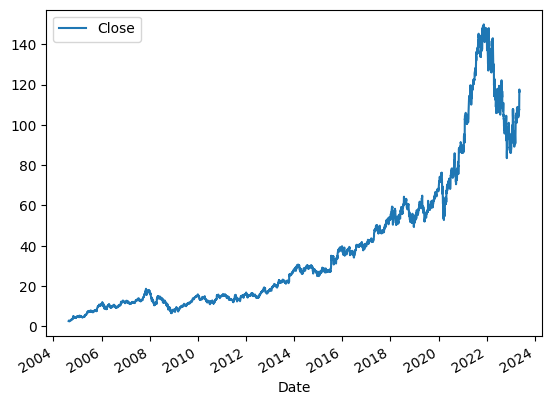

In [135]:
df.plot();

In [136]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(df,
                                '2021-03-25',
                                '2022-03-23',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,101.534500,102.066498,101.626503,101.623001
1,2021-03-26,102.066498,101.626503,101.623001,101.236504
2,2021-03-29,101.626503,101.623001,101.236504,102.289497
3,2021-03-30,101.623001,101.236504,102.289497,102.323502
4,2021-03-31,101.236504,102.289497,102.323502,103.125999
...,...,...,...,...,...
247,2022-03-17,125.950996,129.197998,133.280502,133.839005
248,2022-03-18,129.197998,133.280502,133.839005,136.125504
249,2022-03-21,133.280502,133.839005,136.125504,136.101501
250,2022-03-22,133.839005,136.125504,136.101501,139.867996


In [137]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

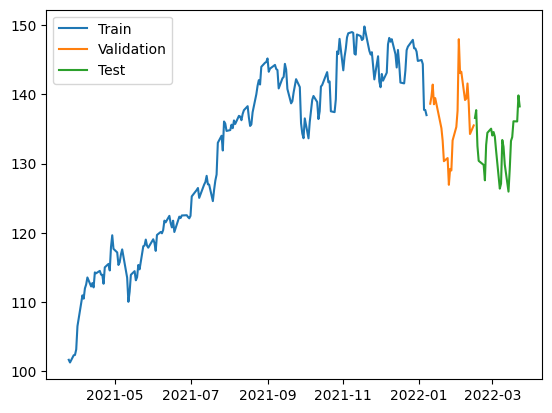

In [138]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test']);

In [139]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100);

Epoch 1/100
7/7 [==============================] - 5s 107ms/step - loss: 17415.6074 - mean_absolute_error: 131.3188 - val_loss: 18455.5137 - val_mean_absolute_error: 135.7596
Epoch 2/100
7/7 [==============================] - 0s 11ms/step - loss: 17218.4629 - mean_absolute_error: 130.5682 - val_loss: 18244.3809 - val_mean_absolute_error: 134.9797
Epoch 3/100
7/7 [==============================] - 0s 10ms/step - loss: 17011.0176 - mean_absolute_error: 129.7680 - val_loss: 18013.6367 - val_mean_absolute_error: 134.1222
Epoch 4/100
7/7 [==============================] - 0s 11ms/step - loss: 16773.5996 - mean_absolute_error: 128.8544 - val_loss: 17747.1680 - val_mean_absolute_error: 133.1250
Epoch 5/100
7/7 [==============================] - 0s 14ms/step - loss: 16499.2910 - mean_absolute_error: 127.7782 - val_loss: 17410.3984 - val_mean_absolute_error: 131.8537
Epoch 6/100
7/7 [==============================] - 0s 11ms/step - loss: 16109.9990 - mean_absolute_error: 126.2436 - val_loss: 16

7/7 [==============================] - 1s 4ms/step


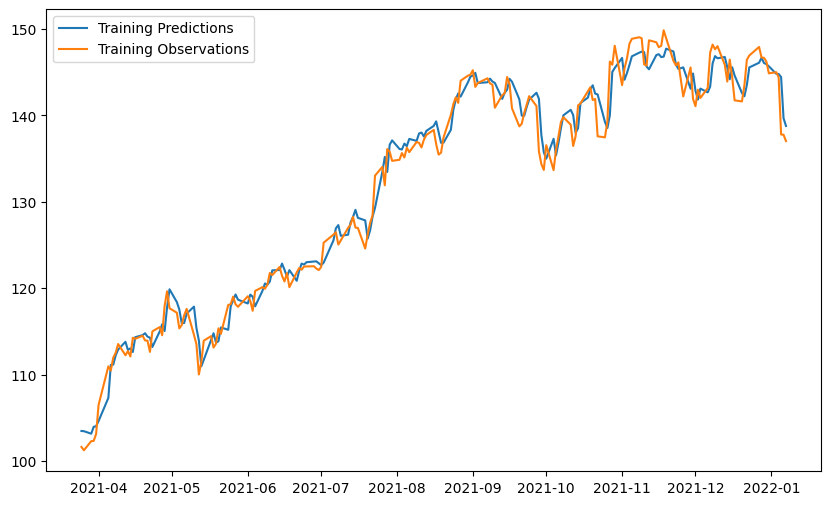

In [140]:
train_predictions = model.predict(X_train).flatten()

fig = plt.figure(figsize=(10, 6))

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations']);

1/1 [==============================] - 0s 22ms/step


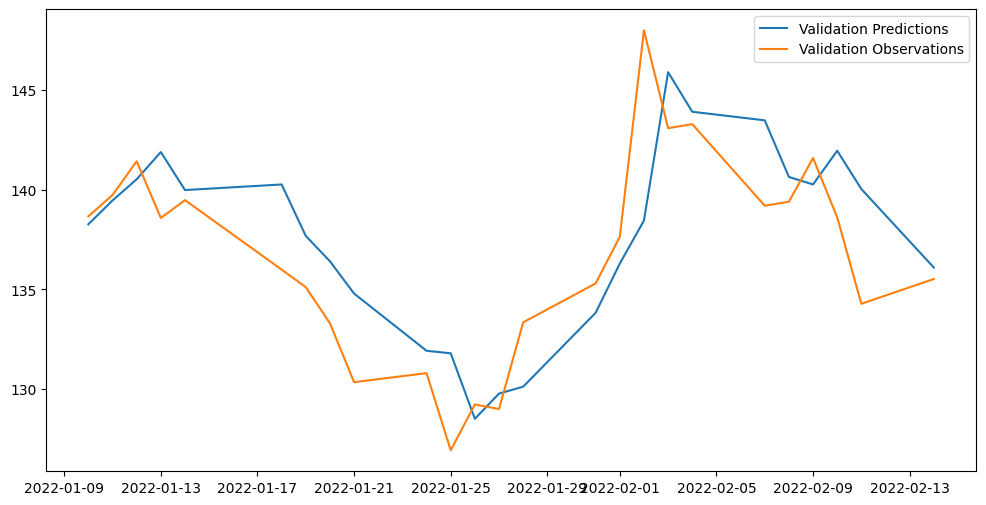

In [141]:
val_predictions = model.predict(X_val).flatten()

fig = plt.figure(figsize=(12, 6))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations']);

1/1 [==============================] - 0s 22ms/step


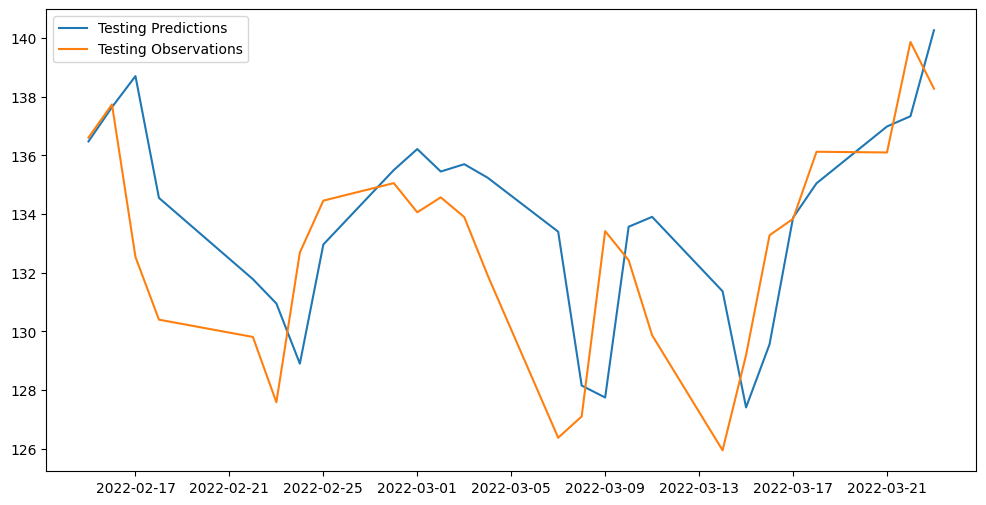

In [142]:
test_predictions = model.predict(X_test).flatten()
fig = plt.figure(figsize=(12, 6))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations']);

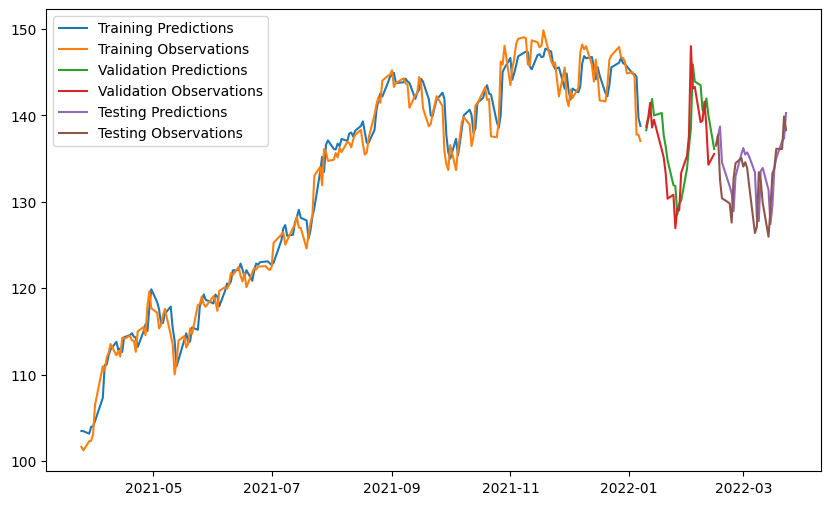

In [143]:
fig = plt.figure(figsize=(10, 6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations']);

In [144]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 24ms/step


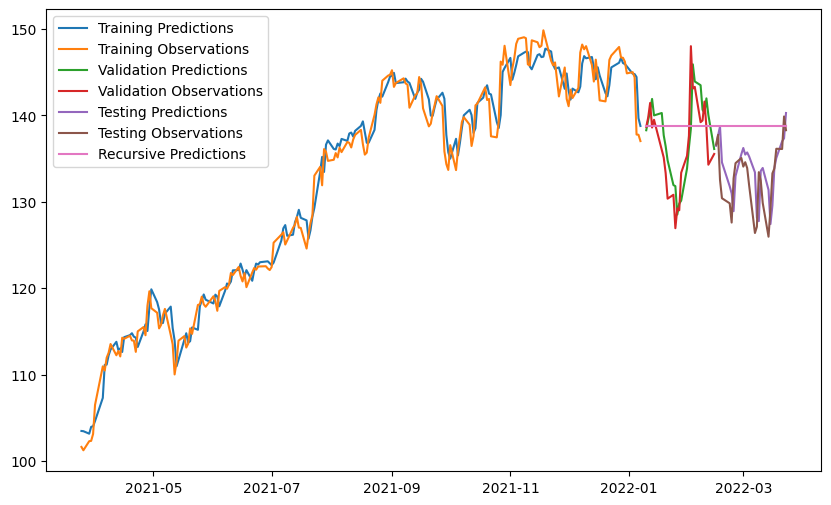

In [145]:
fig = plt.figure(figsize=(10, 6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions']);